# NEXUS tool: case study for the NWSAS basin - energy demand calculations
In this notebook a case study for the Jordan country is covered using the `nexus_tool` package. The water requirements for agricultural irrigation, residential, industrial and tourism use were previously calculated using the Water Evaluation and Planning System (WEAP) model. In this case study, the energy requirements for groundwater pumping, wastewater treatment, desalination of seawater water and pumping for water conveyance are estimated.

First import the package by running the following block:

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import nexus_tool
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

After importing all required packages, the input GIS data is loaded into the variable `df`. Change the `file_path` variable to reflect the name and relative location of your data file. This dataset should already have the water demand for irrigation data.

In [3]:
folder = r'WEAP data/Processed data/Reference'
file_path = f'{folder}/Pipelines_flow.csv'
df = nexus_tool.read_csv(file_path)

## 1. Calculating pumping energy requirements
### 1.1. Creating the model
To create a model simply create an instance of the `nexus_tool.Model()` class and store it in a variable name. The `nexus_tool.Model()` class requires a dataframe as input data. Several other properties and parameter values can be defined by explicitly passing values to them. To see a full list of parameters and their explaination refer to the documentation of the package.

In [4]:
jordan = nexus_tool.Model(df)
jordan.df['Pipe_diameter'] = 0.8 #in m
jordan.df.loc[(df['pipeline']=='KAC'), 'Pipe_diameter'] = 5 #in m

### 1.2. Changing default values for inputs
The names of the properties of the model can be chaned at any time. This is important for the model to know how each property is called withing your input data. To check the current property names run the `nwsas.print_properties()` method, a list with the names of each property and its current value will be displayed:

In [7]:
jordan.print_properties()

Properties names:
    - Reference evapotranspiration (.eto): ETo_
    - Latitude (.lat): lat
    - Elevation (.elevation): elevation
    - Wind speed (.wind): wind
    - Solar radiation (.srad): srad
    - Min temperature (.tmin): tmin
    - Max temperature (.tmax): tmax
    - Avegarage temperature (.tavg): tavg
    - Cropland share column (.crop_share): crop_share
    - Cropland area column (.crop_area): crop_area
    - Harvest seasons names (.seasons): ['init', 'dev', 'mid', 'late']
    - Seasson start suffix (.start): _start
    - Seasson end suffix (.end): _end
    - Cropland column (.crop_column): crop
    - Groundwater table depth (.gw_depth): gw_depth
    - Total dynamic head ground water (.tdh_gw): tdh_gw
    - Total dynamic head surface water (.tdh_sw): tdh_sw


Then you can provide the right names for each property, calling them and assigning a value as:
```python
jordan.crop_column = 'cropland'
jordan.seasons = ['initial', 'development', 'mid-season', 'harvest']
jordan.gw_depth = 'name_of_ground_water_depth'
```

In this particular case we will need to change the following default values:

In [8]:
jordan.elevation = 'elevation_delta'
jordan.L = 'segment_length'
jordan.peak_Q = 'value'
jordan.avg_Q = 'value'

### 1.3. Calculating the Total Dinamic Head (tdh)
First, we will calculate the Total Dinamic Head (tdh), which is a measure in meters that accounts for the elevation difference between two points and the pressure loss in distribution.

For that, the area `A`, the velocity `V`, the Reynolds number `Re` and the friction factor `f` need to be estimated. The `nexus_tool` provides simple functions that will allow for an easy estimation of this variables.

In [9]:
jordan.get_A(inplace=True)
jordan.get_V(inplace=True, axis=0)
jordan.get_Re(inplace=True, axis=0)
jordan.get_f(inplace=True, axis=0)

jordan.get_sw_tdh(inplace = True, axis=0)

### 1.4. Calculating the energy efficiency of the pumping system
To second step compute the energy requirements for pumping water from a groundwater aquifer, first the pumping system efficiency needs to be defined:

$$\text{pumping plant efficiency (%)}= \text{fuel efficiency (%)} \times \text{power unit eff (%)} \times  \text{transmission eff (%)} \times \text{pump eff (%)} \times 100\%$$

**The Power Unit:** can be diesel engine or electric engine. In the first we call it (diesel powered pump) and the second (electric powered pump).
 
Value obtained from FAO1992, pages 26-27:

* Diesel powered pump:
    * Worst case: $0.9\times 0.3\times 0.9\times 0.4 = 10\%\ (0.1)$
    * Best case: $1\times 0.4\times 1\times 0.8 = 32\%\ (0.32)$
    
* Electric powered pump:
    * Worst case: $0.9\times 0.75\times 0.9\times 0.4 = 25\%\ (0.25)$
    * Best case: $1\times 0.85\times 1\times0.8 = 70\%\ (0.7)$

The $\text{fuel efficiency}$ and the $\text{power unit efficiency}$ values can be directly passed to the `.get_pumping_energy()` method, whereas the remaining two efficiency values can be accounted later in the least-cost supply options calculations.

After all required inputs and parameters are computed, the `nwsas.get_GWpumping_energy()` method can used to compute the groundwater pumping energy requirements.

In [10]:
jordan.get_SWpumping_energy(inplace = True, axis=0)

In [11]:
jordan.df['Q_per_meter_seg'] = jordan.df.value * jordan.df.segment_length / jordan.df.pipeline_length
_vec = jordan.df.groupby(['Year','Month','pipeline'])['Q_per_meter_seg'].sum()
jordan.df['Q_per_meter_pl'] = jordan.df.set_index(['Year', 'Month', 'pipeline']).index.map(_vec)

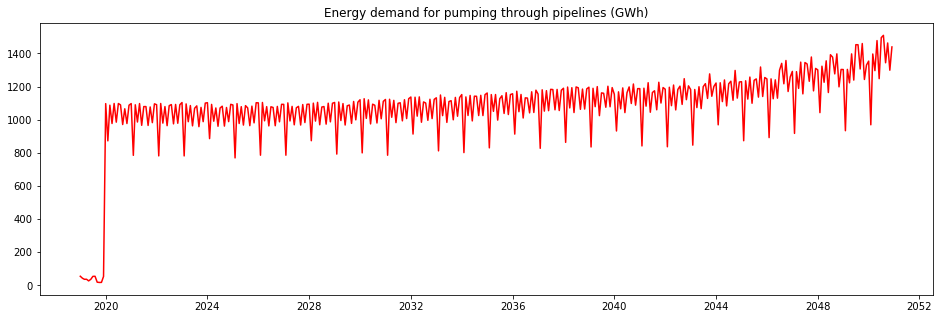

In [12]:
# jordan.df.loc[jordan.df.SWPA_E_<0, 'SWPA_E_'] = 0
y = (jordan.df.groupby(['Year','Month'])['SWPA_E_'].sum()/1000000)
y = y.reset_index()
y['Date'] = [pd.Timestamp(year=i, month=j, day=1) for i, j in zip(y.Year, y.Month)]
_filter = (y.Year.isin(range(2019,2051)))
plt.figure(figsize=(16,5))
plt.title('Energy demand for pumping through pipelines (GWh)')
plt.plot(y.loc[_filter].Date, y.loc[_filter].SWPA_E_, 'r')
# plt.savefig('Energy pipelines.png')

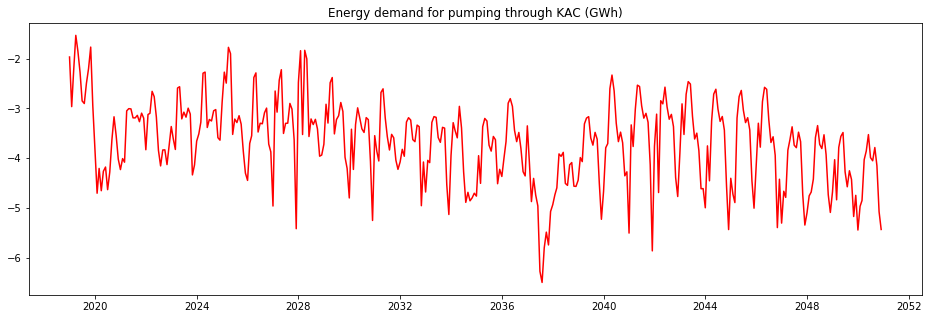

In [14]:
y = (jordan.df.groupby(['Year','Month','pipeline'])['SWPA_E_'].sum()/1000000)
y = y.reset_index()
y['Date'] = [pd.Timestamp(year=i, month=j, day=1) for i, j in zip(y.Year, y.Month)]
pipeline = 'KAC'
_filter = (y.Year.isin(range(2019,2051))) & (y.pipeline==pipeline)
plt.figure(figsize=(16,5))
plt.title(f'Energy demand for pumping through {pipeline} (GWh)')
plt.plot(y.loc[_filter].Date, y.loc[_filter].SWPA_E_, 'r')

In [15]:
# for pipeline in y.pipeline.unique():
#     _filter = (y.Year.isin(range(2019,2051))) & (y.pipeline==pipeline)
#     plt.figure(figsize=(16,5))
#     plt.title(f'Energy demand for pumping through {pipeline} (GWh)')
#     plt.plot(y.loc[_filter].Date, y.loc[_filter].SWPA_E_, 'r')
#     savefig(f'Plots/Energy/Energy {pipeline}.png')

In [16]:
y = (jordan.df.groupby(['Year','Month','pipeline'])['Q_per_meter_pl'].mean()/1000000)
y = y.reset_index()
y['Date'] = [pd.Timestamp(year=i, month=j, day=1) for i, j in zip(y.Year, y.Month)]

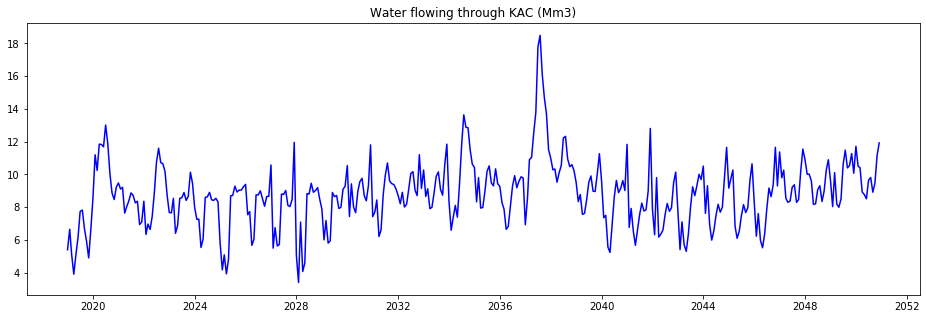

In [17]:
_filter = (y.Year.isin(range(2019,2051))) & (y.pipeline=='KAC')
plt.figure(figsize=(16,5))
plt.title('Water flowing through KAC (Mm3)')
plt.plot(y.loc[_filter].Date, y.loc[_filter].Q_per_meter_pl, 'b')
# plt.savefig('Water KAC.png')

In [18]:
file_path = f'{folder}/Required_demand.csv'
df_required = pd.read_csv(file_path)

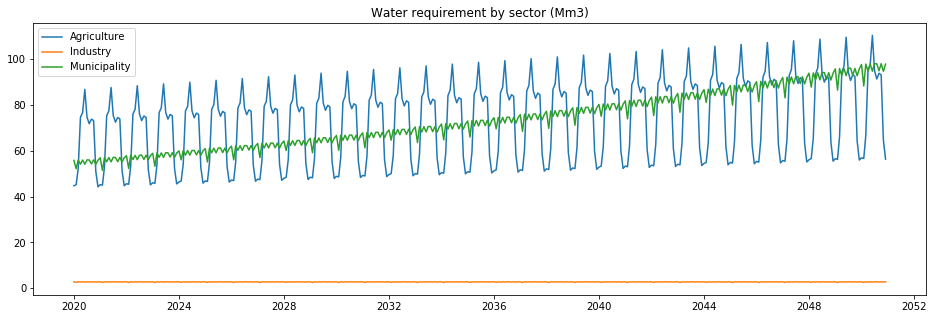

In [19]:
y = (df_required.groupby(['Year','Month','type'])['value'].sum()/1000000)
y = y.reset_index()
y['Date'] = [pd.Timestamp(year=i, month=j, day=1) for i, j in zip(y.Year, y.Month)]
fig, ax = plt.subplots(figsize=(16,5))
plt.title('Water requirement by sector (Mm3)')
# yf = y.loc[y.type=='Agriculture']
yf = y
for t in yf.type.unique():
    _filter = (yf.Year.isin(range(2020,2051))) & (yf.type==t)
    ax.plot(yf.loc[_filter].Date, yf.loc[_filter].value, label=t)
ax.legend()

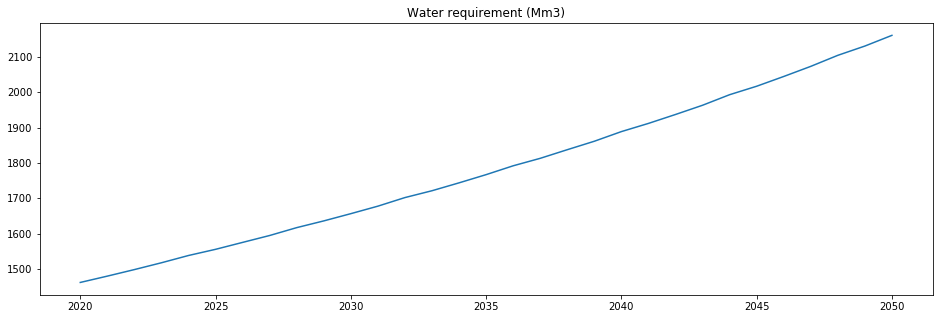

In [20]:
y = (df_required.groupby(['Year'])['value'].sum()/1000000)
y = y.reset_index()
# y['Date'] = [pd.Timestamp(year=i, month=j, day=1) for i, j in zip(y.Year, y.Month)]
fig, ax = plt.subplots(figsize=(16,5))
plt.title('Water requirement (Mm3)')
# yf = y.loc[y.type=='Agriculture']
yf = y
_filter = (yf.Year.isin(range(2020,2051)))
ax.plot(yf.loc[_filter].Year, yf.loc[_filter].value)

In [21]:
file_path = f'{folder}/Delivered_demand.csv'
df_delivered = pd.read_csv(file_path)

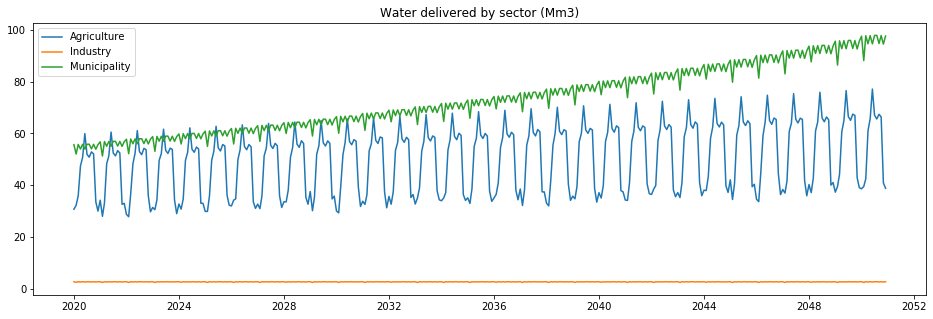

In [22]:
y = (df_delivered.groupby(['Year','Month','type'])['value'].sum()/1000000)
y = y.reset_index()
y['Date'] = [pd.Timestamp(year=i, month=j, day=1) for i, j in zip(y.Year, y.Month)]
fig, ax = plt.subplots(figsize=(16,5))
plt.title('Water delivered by sector (Mm3)')
# yf = y.loc[y.type=='Agriculture']
yf = y

for t in yf.type.unique():
    _filter = (yf.Year.isin(range(2020,2051))) & (yf.type==t)
    ax.plot(yf.loc[_filter].Date, yf.loc[_filter].value, label=t)
ax.legend()

In [23]:
df_difference = df_required.copy()

In [24]:
y1 = (df_required.groupby(['Year','Month','type'])['value'].sum()/1000000)
y1 = y1.reset_index()
y2 = (df_delivered.groupby(['Year','Month','type'])['value'].sum()/1000000)
y2 = y2.reset_index()
y = y1.copy()
y['value'] = y1.value - y2.value

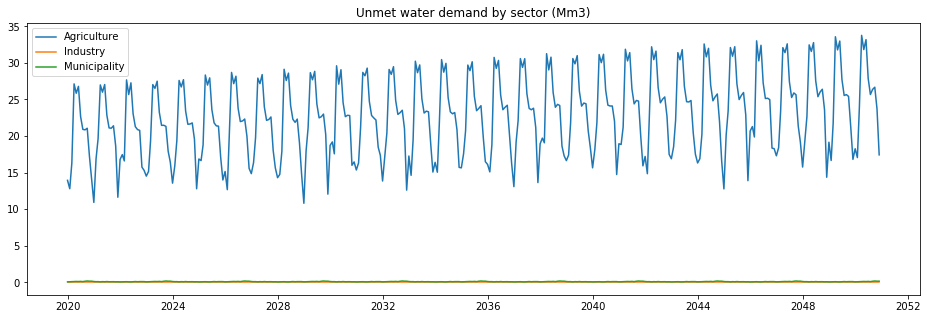

In [25]:
y['Date'] = [pd.Timestamp(year=i, month=j, day=1) for i, j in zip(y.Year, y.Month)]

fig, ax = plt.subplots(figsize=(16,5))
plt.title('Unmet water demand by sector (Mm3)')
# yf = y.loc[y.type=='Agriculture']
yf = y
for t in yf.type.unique():
    _filter = (yf.Year.isin(range(2020,2051))) & (yf.type==t)
    ax.plot(yf.loc[_filter].Date, yf.loc[_filter].value, label=t)
ax.legend()

In [26]:
file_path = f'{folder}/Groundwater_supply.csv'
df_groundwater = pd.read_csv(file_path)

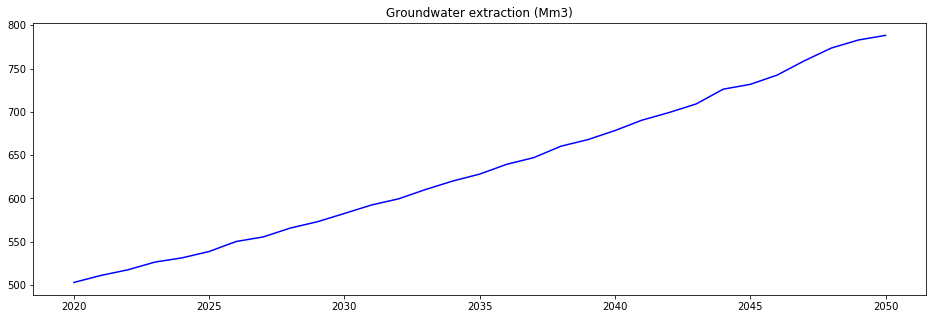

In [27]:
y = df_groundwater.groupby(['Year'])['value'].sum()/1000000
y = y.reset_index()
# y['Date'] = [pd.Timestamp(year=i, month=j, day=1) for i, j in zip(y.Year, y.Month)]
plt.figure(figsize=(16,5))
plt.title('Groundwater extraction (Mm3)')
_filter = (y.Year.isin(range(2020,2051)))
plt.plot(y.loc[_filter].Year, y.loc[_filter].value, 'b')

# fig, ax = plt.subplots(figsize=(16,5))
# plt.title('Groundwater extraction (Mm3)')
# # yf = y.loc[y.type=='Agriculture']
# yf = y
# for p in yf.point.unique():
#     _filter = (yf.Year.isin(range(2020,2051))) & (yf.point==p)
#     ax.plot(yf.loc[_filter].Date, yf.loc[_filter].value, label=p)
# ax.legend()

In [28]:
jordan_gw = nexus_tool.Model(df_groundwater)
jordan_gw.df['Pipe_diameter'] = 0.4

jordan_gw.elevation = 'wtd'
jordan_gw.L = 'wtd'
jordan_gw.peak_Q = 'value'
jordan_gw.avg_Q = 'value'

jordan_gw.get_A(inplace=True)
jordan_gw.get_V(inplace=True, axis=0)
jordan_gw.get_Re(inplace=True, axis=0)
jordan_gw.get_f(inplace=True, axis=0)

jordan_gw.get_sw_tdh(inplace = True, axis=0)
jordan_gw.get_SWpumping_energy(inplace = True, axis=0)

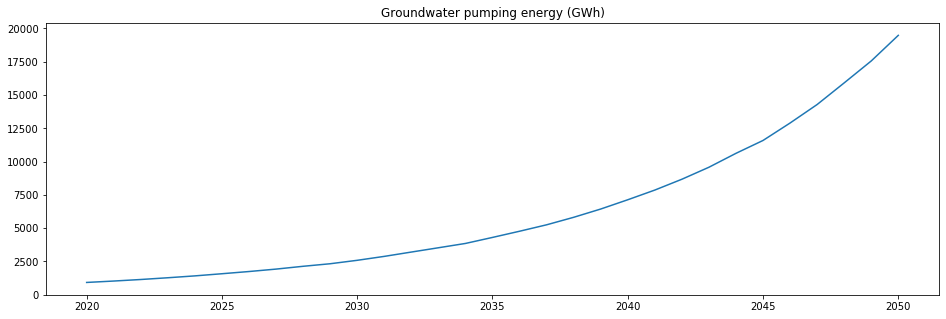

In [29]:
y = (jordan_gw.df.groupby(['Year'])['SWPA_E_'].sum()/1000000)
y = y.reset_index()
# y['Date'] = [pd.Timestamp(year=i, month=j, day=1) for i, j in zip(y.Year, y.Month)]
fig, ax = plt.subplots(figsize=(16,5))
plt.title('Groundwater pumping energy (GWh)')
_filter = (y.Year.isin(range(2020,2051)))
ax.plot(y.loc[_filter].Year, y.loc[_filter].SWPA_E_)

In [30]:
file_path = f'{folder}/WWTP_inflow.csv'
df_wwtp = pd.read_csv(file_path)

In [31]:
wwtp_energy_int = 0.6 # kWh/m3
df_wwtp['SWPA_E_'] = df_wwtp.value * wwtp_energy_int

In [32]:
folder = r'dashboard/data/scenarios/Reference/'
jordan.df.to_csv(f'{folder}Pipelines_data.csv', index=False)
df_required.to_csv(f'{folder}Water_requirements.csv', index=False)
df_delivered.to_csv(f'{folder}Water_delivered.csv', index=False)
jordan_gw.df.to_csv(f'{folder}Groundwater_pumping.csv', index=False)
df_wwtp.to_csv(f'{folder}wwtp_data.csv', index=False)